<a href="https://colab.research.google.com/github/siddharth0517/NVIDIA-stock-price-prediction-using-LSTM/blob/main/NVIDIA_stock_price_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA stock price prediction using LSTM

**1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

**2. Downloading and Cleaning Dataset**

In [2]:
ticker = "NVDA"
data = yf.download(ticker, start="2015-01-01", end="2025-02-15")

[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.columns)

MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])


In [4]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463942,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000


In [5]:
data.columns = ['_'.join(col).strip() for col in data.columns.values]

In [6]:
data.head()

,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Volume_NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463942,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000


# EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2546 entries, 2015-01-02 to 2025-02-14
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_NVDA   2546 non-null   float64
 1   High_NVDA    2546 non-null   float64
 2   Low_NVDA     2546 non-null   float64
 3   Open_NVDA    2546 non-null   float64
 4   Volume_NVDA  2546 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 119.3 KB


In [8]:
data.describe()

,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Volume_NVDA
count,2546.000000,2546.000000,2546.000000,2546.000000,2.546000e+03
mean,22.118223,22.521747,21.673405,22.119066,4.653854e+08
std,34.367199,35.010048,33.667039,34.398855,2.534116e+08
min,0.459382,0.468023,0.454582,0.463703,5.244800e+07
25%,3.565947,3.634901,3.509846,3.579444,3.018592e+08
50%,6.565824,6.656277,6.441706,6.525502,4.134380e+08
75%,22.058110,22.367197,21.475371,22.050870,5.598472e+08
max,149.429993,153.130005,147.820007,153.029999,3.692928e+09


*Outlier Detection*

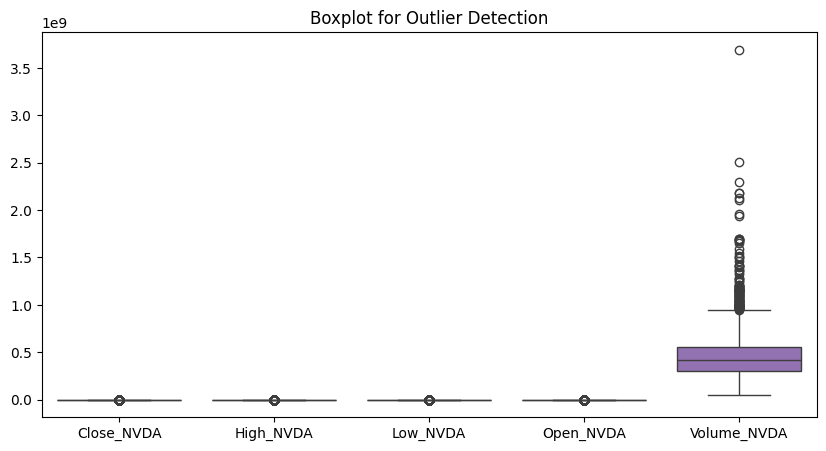

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA']])
plt.title("Boxplot for Outlier Detection")
plt.show()

*Time Series Trends*

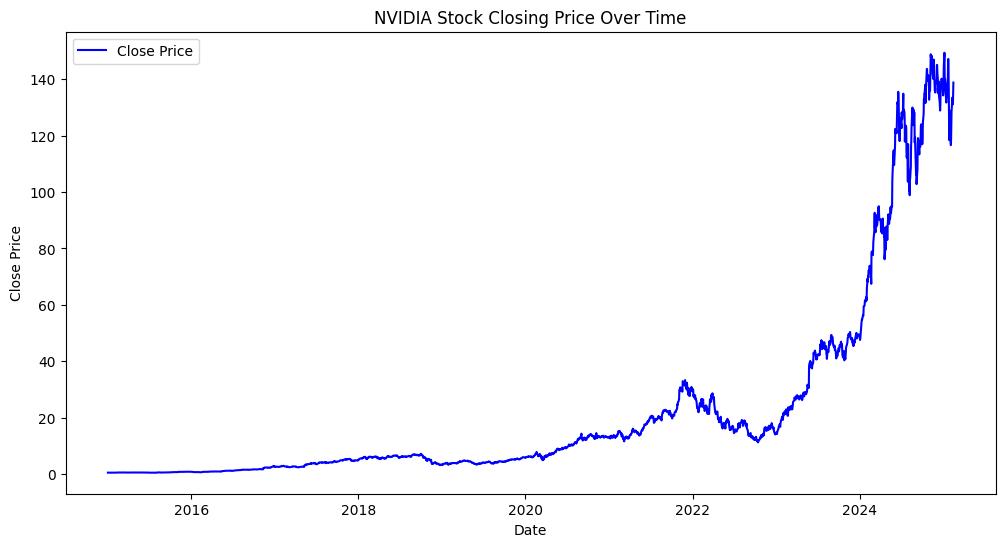

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close_NVDA'], label='Close Price', color='blue')
plt.title('NVIDIA Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

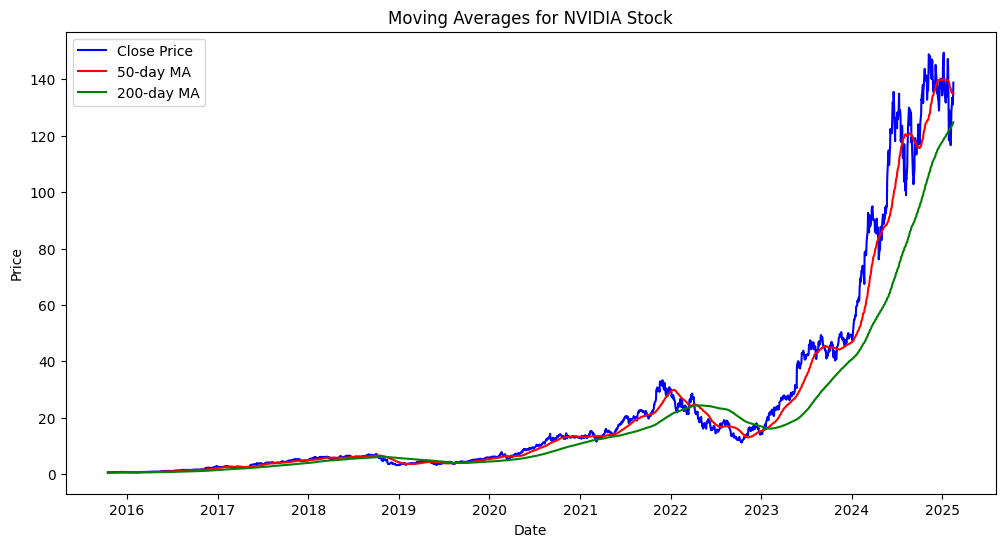

In [22]:
data['MA50'] = data['Close_NVDA'].rolling(window=50).mean()
data['MA200'] = data['Close_NVDA'].rolling(window=200).mean()

data = data.dropna()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close_NVDA'], label='Close Price', color='blue')
plt.plot(data.index, data['MA50'], label='50-day MA', color='red')
plt.plot(data.index, data['MA200'], label='200-day MA', color='green')
plt.title('Moving Averages for NVIDIA Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


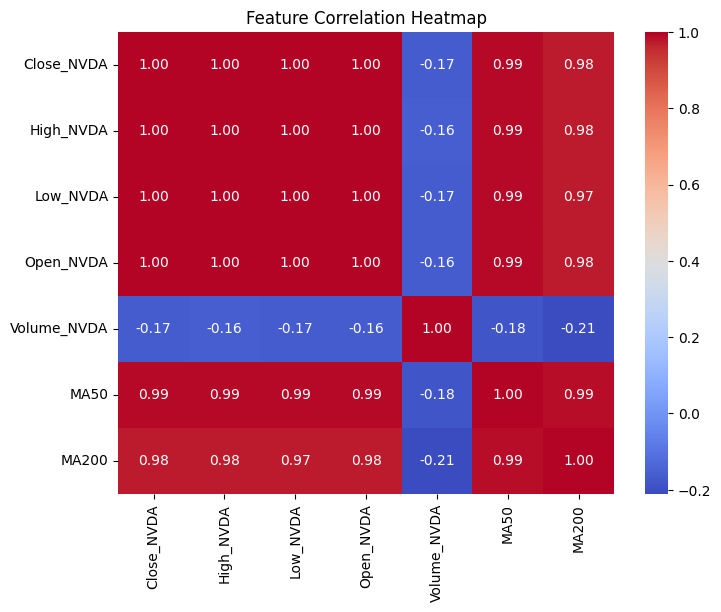

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


**3. Data Split**

In [23]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

**4. Normalization**

In [24]:
from sklearn.preprocessing import MinMaxScaler

target_column = 'Close_NVDA'
features = ['Open_NVDA', 'MA50','MA200']

scaler_train = MinMaxScaler(feature_range=(0,1))
scaler_test = MinMaxScaler(feature_range=(0,1))

In [25]:
train_scaled = scaler_train.fit_transform(train_data[features])

test_scaled = scaler_test.fit_transform(test_data[features])

train_scaled_df = pd.DataFrame(train_scaled, columns=features, index=train_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_data.index)

print("Train data shape:", train_scaled_df.shape)
print("Test data shape:", test_scaled_df.shape)

Train data shape: (1877, 3)
Test data shape: (470, 3)


**5. Create Sequence for LSTM**

In [26]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1817, 60, 3)
y_train shape: (1817,)
X_test shape: (410, 60, 3)
y_test shape: (410,)


**6. Building The Model**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print("NaN in training features:", np.isnan(X_train).any())
print("NaN in training target:", np.isnan(y_train).any())
print("Infinity in training features:", np.isinf(X_train).any())
print("Infinity in training target:", np.isinf(y_train).any())

NaN in training features: False
NaN in training target: False
Infinity in training features: False
Infinity in training target: False


In [29]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0115
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0069
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.7614e-04 - val_loss: 0.0049
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1762e-04 - val_loss: 0.0043
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3527e-04 - val_loss: 0.0045
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8373e-04 - val_loss: 0.0043
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4916e-04 - val_loss: 0.0038
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6123e-04 - val_loss: 0.0050
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.2920e-04 - val_loss: 0.0048
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8885e-04 - val_loss: 0.0033
Epoch 12/100
46/46 ━

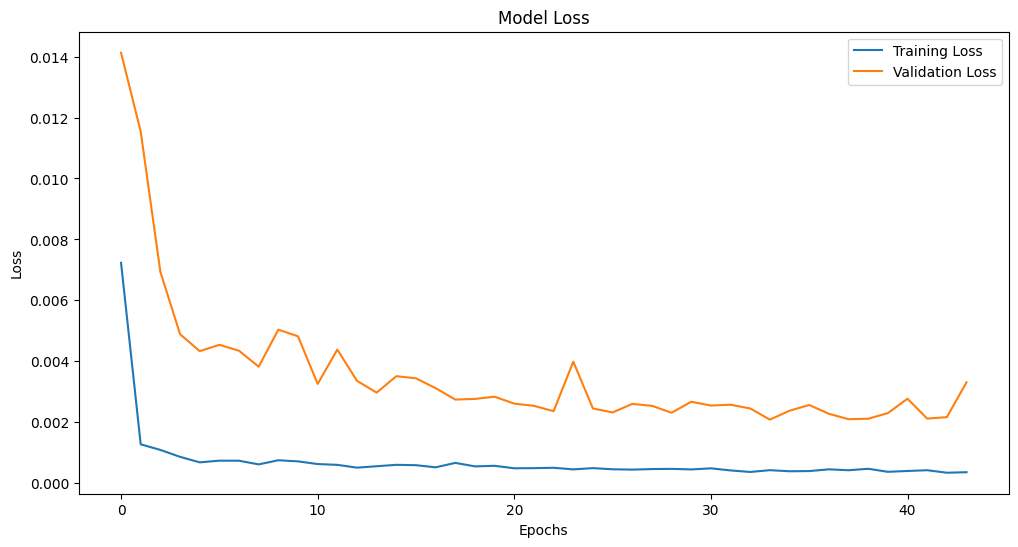

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
y_pred = model.predict(X_test)

# Inverse transform to get actual stock prices
y_test_actual = np.zeros((len(y_test), len(features)))
y_test_actual[:, 0] = y_test
y_test_actual = scaler_test.inverse_transform(y_test_actual)[:, 0]

y_pred_actual = np.zeros((len(y_pred), len(features)))
y_pred_actual[:, 0] = y_pred.flatten()
y_pred_actual = scaler_test.inverse_transform(y_pred_actual)[:, 0]

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"RMSE: {rmse}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 5.841491289566206


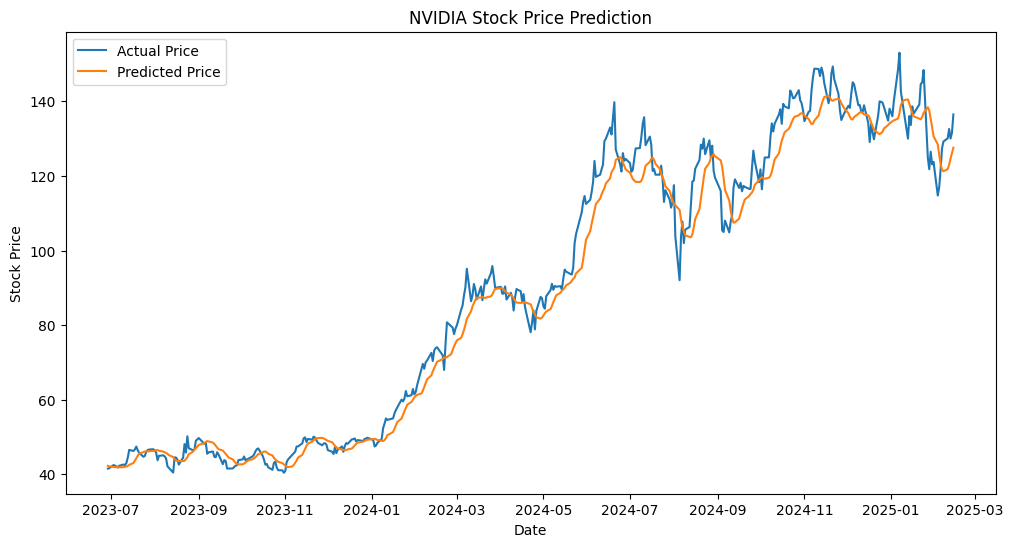

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[seq_length:], y_test_actual, label='Actual Price')
plt.plot(test_data.index[seq_length:], y_pred_actual, label='Predicted Price')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [33]:
# 1. Get the most recent window of data
last_sequence = test_scaled[-seq_length:]  # Get last 60 days from test data

# 2. Reshape for LSTM input (samples, time steps, features)
last_sequence = last_sequence.reshape(1, seq_length, len(features))

# 3. Make prediction
next_day_prediction = model.predict(last_sequence)

# 4. Inverse transform to get actual stock price
next_day_array = np.zeros((1, len(features)))
next_day_array[0, 0] = next_day_prediction[0, 0]
next_day_price = scaler_test.inverse_transform(next_day_array)[0, 0]

# 5. Get the current date and calculate next day
last_date = test_data.index[-1]
next_date = last_date + pd.Timedelta(days=1)
if next_date.weekday() >= 5:  # If it's weekend
    next_date = next_date + pd.Timedelta(days=7-next_date.weekday())  # Move to Monday

print(f"Predicted stock price for {next_date.date()}: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted stock price for 2025-02-17: $129.32


**8. Save Model**

In [34]:
model.save("nvda_lstm_model.keras")
np.save("scaler_train.npy", scaler_train.get_params())
np.save("scaler_test.npy", scaler_test.get_params())